**这个notebook记录了我在kaggle上创建、训练模型的过程，这一模型是项目的表情识别部分中最终应用的模型。**

**在kaggle平台上的链接：https://www.kaggle.com/code/nkheros/notebook0ea2304db4/notebook ，在这里有更多训练过程的log记录。**

**这里的训练直接采用预处理好的数据集，这些数据集提前上传到了平台上。**

**kaggle环境为python3.7，可能会产生一些版本差异(本机3.8.10)，但并未实质性地影响模型的训练。**

**训练过程中有很多参数可调，这些都会大大影响最终训练结果，但限于时间，我无法一一尝试，训练过程中模型的动态调整并不多**

In [1]:
import os
#将数据集拷贝到输出路径并增加几个空文件夹，从而都对齐到8个类
%cp -r ../input/facial-emotion-recognition ./
os.mkdir('./facial-emotion-recognition/CK+/6')
os.mkdir('./facial-emotion-recognition/CK+/7')
os.mkdir('./facial-emotion-recognition/fer2013plus/train/7')
os.mkdir('./facial-emotion-recognition/fer2013plus/val/7')
os.mkdir('./facial-emotion-recognition/fer2013plus/test/7')
os.mkdir('./facial-emotion-recognition/jaffe/7')

**定义模型创建、训练、评估的方法。
需要说明的是CNN网络的输入采用bgr的格式，与opencv相统一。**

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import os

def create_model2():
    """
    复现《A Real-time Facial Expression Recognizer using Deep Neural Network》,该论文在fer2013比赛中取得了最好的表现(准确率约70%)
    """
    input_data = keras.layers.Input(shape=(48, 48, 3))

    # crop to 5 pieces(Sequential模型实现不了剪切为多份的效果，需使用Model模型)，后面的都是共享层
    x1 = keras.layers.Cropping2D(cropping=((0, 6), (0, 6)))(input_data)  # 左上角
    x2 = keras.layers.Cropping2D(cropping=((0, 6), (6, 0)))(input_data)  # 右上角
    x3 = keras.layers.Cropping2D(cropping=((3, 3), (3, 3)))(input_data)  # 中间
    x4 = keras.layers.Cropping2D(cropping=((6, 0), (0, 6)))(input_data)  # 左下角
    x5 = keras.layers.Cropping2D(cropping=((6, 0), (6, 0)))(input_data)  # 右下角

    x = [x1, x2, x3, x4, x5]

    # convolution 1
    pad1 = keras.layers.ZeroPadding2D(padding=(2, 2))
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=(5, 5))
    bn1 = keras.layers.BatchNormalization()
    activation1 = keras.layers.Activation('relu')

    # pooling 1
    pool1 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))

    # convolution 2
    pad2 = keras.layers.ZeroPadding2D(padding=(1, 1))
    conv2 = keras.layers.Conv2D(filters=32, kernel_size=(4, 4))
    bn2 = keras.layers.BatchNormalization()
    activation2 = keras.layers.Activation('relu')

    # pooling 2
    pool2 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))

    # convolution 3
    pad3 = keras.layers.ZeroPadding2D(padding=(2, 2))
    conv3 = keras.layers.Conv2D(filters=64, kernel_size=(5, 5))
    bn3 = keras.layers.BatchNormalization()
    activation3 = keras.layers.Activation('relu')

    # pooling 3
    pool3 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))

    # flatten
    flatten = keras.layers.Flatten()

    # fully-connected 1
    dense1 = keras.layers.Dense(units=2048, kernel_regularizer=keras.regularizers.l2(0.0001))
    bn4 = keras.layers.BatchNormalization()
    activation4 = keras.layers.Activation('relu')
    dropout1 = keras.layers.Dropout(0.4)

    # fully-connected 2
    dense2 = keras.layers.Dense(units=1024, kernel_regularizer=keras.regularizers.l2(0.0001))
    bn5 = keras.layers.BatchNormalization()
    activation5 = keras.layers.Activation('relu')
    dropout2 = keras.layers.Dropout(0.4)

    # output layer
    dense3 = keras.layers.Dense(8, activation='softmax')

    for i in range(5):
        x[i] = pad1(x[i])
        x[i] = conv1(x[i])
        x[i] = bn1(x[i])
        x[i] = activation1(x[i])
        x[i] = pool1(x[i])
        x[i] = pad2(x[i])
        x[i] = conv2(x[i])
        x[i] = bn2(x[i])
        x[i] = activation2(x[i])
        x[i] = pool2(x[i])
        x[i] = pad3(x[i])
        x[i] = conv3(x[i])
        x[i] = bn3(x[i])
        x[i] = activation3(x[i])
        x[i] = pool3(x[i])
        x[i] = flatten(x[i])
        x[i] = dense1(x[i])
        x[i] = bn4(x[i])
        x[i] = activation4(x[i])
        x[i] = dropout1(x[i])
        x[i] = dense2(x[i])
        x[i] = bn5(x[i])
        x[i] = activation5(x[i])
        x[i] = dropout2(x[i])
        x[i] = dense3(x[i])

    output_data = keras.layers.Average()(x[0:5])
    model = keras.Model(inputs=input_data, outputs=output_data)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

    model.build(input_shape=(None, 48, 48, 3))
    model.summary()

    return model


def img_rgb2bgr(img):
    """
    :param img:
    :return:
    将flow_from_directory读取图片的rgb格式转化为bgr格式，这样训练时也统一采用了bgr格式，使CNN的输入与opencv相对应
    """
    return img[:, :, :: -1]


def train_model(model, epochs=1, batch_size=64, src='fer2013plus', save_path=None, visualize=False):
    """
    :param model: 
    :param epochs: 
    :param batch_size: 
    :param src: {fer2013plus, CK+, AffectNet, jaffe} 数据集名称
    :param save_path: 保存模型的路径
    :param visualize: 是否绘制损失曲线
    :return: 训练后的模型
    """
    base_path = os.path.join('./facial-emotion-recognition', src)
    train_set = base_path
    val_set = base_path
    if src == 'fer2013plus' or src == 'AffectNet':
        train_set = os.path.join(base_path, 'train')
        val_set = os.path.join(base_path, 'val')

    height = 48
    width = 48

    # 图片产生器，在批量中对数据进行增强，扩充数据集大小
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255, #标准化
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=40, # 图片随机转动的角度范围
        width_shift_range=0.2, # 图片宽度的某个比例, 图片水平偏移的幅度
        height_shift_range=0.2, # 图片高度的某个比例, 图片竖直偏移的幅度
        shear_range=0.2, # 剪切强度（逆时针方向的剪切变换角度）
        zoom_range=0.2, # 随机缩放范围
        horizontal_flip=True, # 随机水平翻转
        fill_mode='nearest', # 例如，aaaaaaaa|abcd|dddddddd
        preprocessing_function=eval('img_rgb2bgr') # 统一为BGR顺序
    )

    train_generator = train_datagen.flow_from_directory(
        train_set,
        target_size=(height, width),
        batch_size=batch_size,
        seed=7,
        shuffle=True, #每次打乱随机取
        class_mode='categorical' #独热编码
    )

    valid_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255,
        preprocessing_function=eval('img_rgb2bgr')
    )
    valid_generator = valid_datagen.flow_from_directory(
        val_set,
        target_size=(height, width),
        batch_size=batch_size,
        seed=7,
        shuffle=True,
        class_mode='categorical'
    )

    train_num = train_generator.samples
    valid_num = valid_generator.samples

    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_num // batch_size,
        epochs=epochs,
        verbose=1, #显示进度条
        callbacks=[es],
        validation_data=valid_generator,
        validation_steps=valid_num // batch_size
    )

    if save_path is not None:
        model.save(save_path)

    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        # Plot training & validation accuracy values
        axes[0].plot(history.history['accuracy'])
        axes[0].plot(history.history['val_accuracy'])
        axes[0].set_title('Model accuracy')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        axes[1].plot(history.history['loss'])
        axes[1].plot(history.history['val_loss'])
        axes[1].set_title('Model loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    return model


# 模型评估函数
def evaluate_model(model, batch_size=64, src='fer2013plus'):
    test_set = os.path.join('./facial-emotion-recognition', src)
    if src == "AffectNet":
        test_set = os.path.join(test_set, 'val')
    elif src == "fer2013plus":
        test_set = os.path.join(test_set, 'test')
    height = 48
    width = 48

    test_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255,
        preprocessing_function=eval('img_rgb2bgr')
    )
    test_generator = test_datagen.flow_from_directory(
        test_set,
        target_size=(height, width),
        batch_size=batch_size,
        seed=7,
        shuffle=True,
        class_mode='categorical'
    )

    score = model.evaluate(
        x=test_generator,  # Generator yielding 
        steps=test_generator.samples // batch_size,  # number of steps (batches of samples) to yield from generator before stopping
        max_queue_size=10,  # maximum size for the generator queue
    )
    print("Performance on test_set %s: loss: %.6f - acc: %.6f" % (src, score[0], score[1]))

**创建模型，先在fer2013plus数据集上训练，初始batch_size调大(2048)，为了更快地降低训练集损失。**

2022-07-22 03:38:36.347058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 03:38:36.456451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 03:38:36.457668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 03:38:36.459826: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 42, 42, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 42, 42, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d_2 (Cropping2D)       (None, 42, 42, 3)    0           input_1[0][0]                    
______________________________________________________________________________________________

2022-07-22 03:38:45.995507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-22 03:38:52.797825: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 103s 2s/step - loss: 2.2899 - accuracy: 0.2295 - val_loss: 2.2906 - val_accuracy: 0.1655
Epoch 2/20
37/37 [==============================] - 90s 2s/step - loss: 2.0664 - accuracy: 0.2957 - val_loss: 2.3909 - val_accuracy: 0.2310
Epoch 3/20
37/37 [==============================] - 91s 2s/step - loss: 1.9733 - accuracy: 0.3370 - val_loss: 2.1706 - val_accuracy: 0.3535
Epoch 4/20
37/37 [==============================] - 90s 2s/step - loss: 1.8935 - accuracy: 0.3695 - val_loss: 2.1877 - val_accuracy: 0.3809
Epoch 5/20
37/37 [==============================] - 90s 2s/step - loss: 1.8205 - accuracy: 0.3992 - val_loss: 2.0902 - val_accuracy: 0.4087
Epoch 6/20
37/37 [==============================] - 89s 2s/step - loss: 1.7617 - accuracy: 0.4190 - val_loss: 2.2484 - val_accuracy: 0.4126
Epoch 7/20
37/37 [==============================] - 89s 2s/step - loss: 1.7092 - accuracy: 0.4363 - val_loss: 1.6132 - val_accuracy: 0.4653
Epoch 8/20
37/37 [============

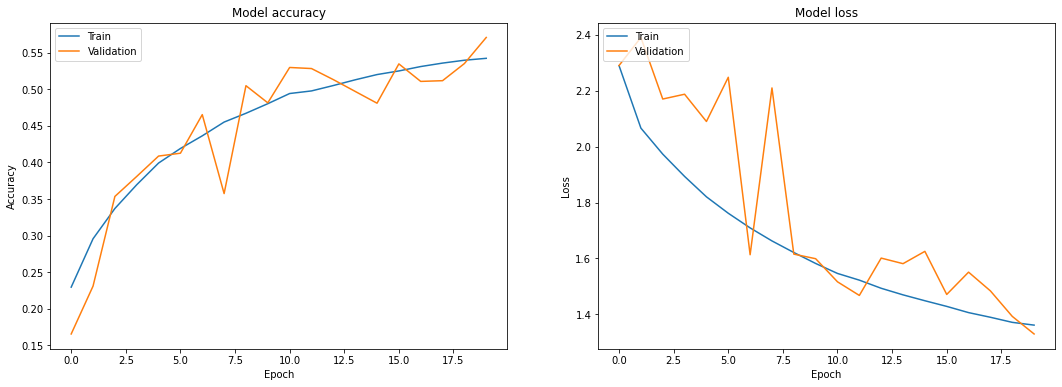

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Found 3589 images belonging to 8 classes.
56/56 [==============================] - 1s 25ms/step - loss: 1.2805 - accuracy: 0.5831
Performance on test_set fer2013plus: loss: 1.280501 - acc: 0.583147


In [3]:
model = create_model2()
model = train_model(model, epochs=20, batch_size=2048, visualize=True)
model.save('./FER_model.h5')
evaluate_model(model)

**首先，从模型摘要中可以直观地看出，输入图像被裁剪为5份，这5份经过共享层后做平均得到最终的结果。**

**其次，观察训练过程，第一波训练中，训练集和验证集的准确率、损失都在转好，测试集上的准确率约58%。**

**最后，前面的几个红框里是关于kaggle创建GPU环境的信息，最后一个红框出现了警告信息，是由于网络中自定义层(各个共享层)未重写get_config而在模型保存时产生的警告。**

**接下来，稍微调小batch_size，继续训练**

Found 76393 images belonging to 8 classes.
Found 3589 images belonging to 8 classes.
Epoch 1/20
149/149 [==============================] - 88s 590ms/step - loss: 1.4927 - accuracy: 0.4964 - val_loss: 1.4707 - val_accuracy: 0.5237
Epoch 2/20
149/149 [==============================] - 88s 591ms/step - loss: 1.4465 - accuracy: 0.5135 - val_loss: 1.4897 - val_accuracy: 0.5095
Epoch 3/20
149/149 [==============================] - 89s 598ms/step - loss: 1.4184 - accuracy: 0.5212 - val_loss: 1.5149 - val_accuracy: 0.4805
Epoch 4/20
149/149 [==============================] - 89s 594ms/step - loss: 1.3917 - accuracy: 0.5322 - val_loss: 1.3585 - val_accuracy: 0.5352
Epoch 5/20
149/149 [==============================] - 88s 590ms/step - loss: 1.3743 - accuracy: 0.5386 - val_loss: 1.3507 - val_accuracy: 0.5647
Epoch 6/20
149/149 [==============================] - 88s 593ms/step - loss: 1.3576 - accuracy: 0.5433 - val_loss: 1.4856 - val_accuracy: 0.5212
Epoch 7/20
149/149 [=========================

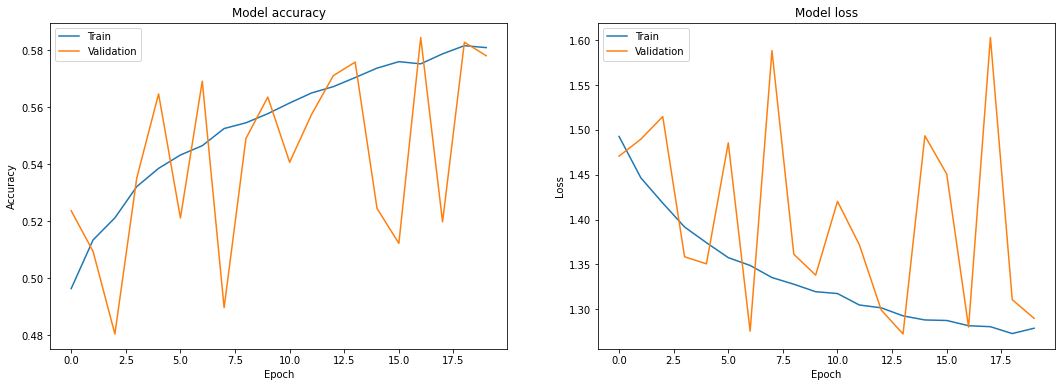

Found 3589 images belonging to 8 classes.
56/56 [==============================] - 1s 23ms/step - loss: 1.2643 - accuracy: 0.5818
Performance on test_set fer2013plus: loss: 1.264314 - acc: 0.581752


In [4]:
model == keras.models.load_model('./FER_model.h5')
model = train_model(model, epochs=20, batch_size=512, visualize=True)
model.save('./FER_model.h5')
evaluate_model(model)

**观察准确率和损失曲线，发现训练集的情况还在稳步变好，但验证集的情况则摇摆不定，训练结束后在测试集上的准确率也没有提高（仍58%），说明训练的不精，这种情况下应当减小batch_size继续训练。**

Found 76393 images belonging to 8 classes.
Found 3589 images belonging to 8 classes.
Epoch 1/20
1193/1193 [==============================] - 100s 84ms/step - loss: 1.6360 - accuracy: 0.4804 - val_loss: 1.7237 - val_accuracy: 0.4166
Epoch 2/20
1193/1193 [==============================] - 99s 83ms/step - loss: 1.5299 - accuracy: 0.5106 - val_loss: 1.4513 - val_accuracy: 0.5430
Epoch 3/20
1193/1193 [==============================] - 99s 83ms/step - loss: 1.4960 - accuracy: 0.5186 - val_loss: 1.4104 - val_accuracy: 0.5432
Epoch 4/20
1193/1193 [==============================] - 102s 86ms/step - loss: 1.4702 - accuracy: 0.5262 - val_loss: 1.4438 - val_accuracy: 0.5396
Epoch 5/20
1193/1193 [==============================] - 101s 85ms/step - loss: 1.4519 - accuracy: 0.5327 - val_loss: 1.3594 - val_accuracy: 0.5619
Epoch 6/20
1193/1193 [==============================] - 101s 84ms/step - loss: 1.4354 - accuracy: 0.5338 - val_loss: 1.4168 - val_accuracy: 0.5343
Epoch 7/20
1193/1193 [=============

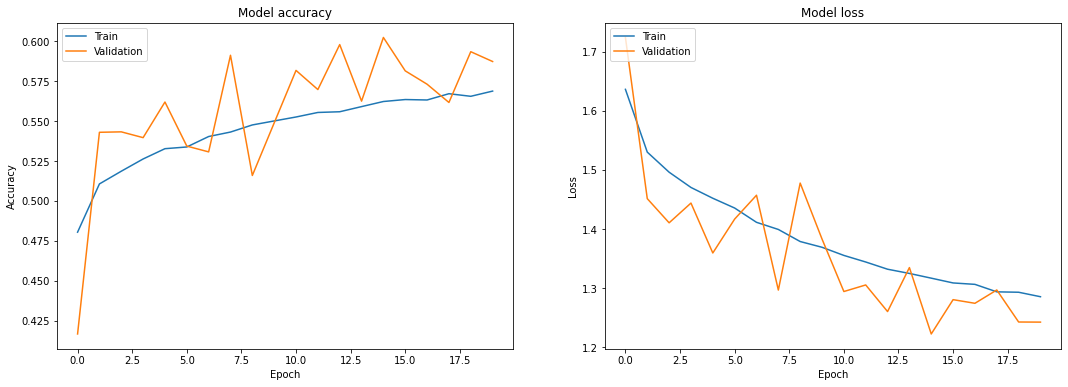

Found 3589 images belonging to 8 classes.
56/56 [==============================] - 2s 31ms/step - loss: 1.2177 - accuracy: 0.5954
Performance on test_set fer2013plus: loss: 1.217666 - acc: 0.595424


In [5]:
model == keras.models.load_model('./FER_model.h5')
model = train_model(model, epochs=20, batch_size=64, visualize=True)
model.save('./FER_model.h5')
evaluate_model(model)

**这一次训练的batch_size调为了64，在训练集情况变好的同时，验证集和测试集的情况也变好了(测试集：58%->59%)**

**接下来将batch_size调为32，进行精细化的训练，有一种说法是batch_size应自始至终保持在32以内，才可能训练出最好的模型**

Found 76393 images belonging to 8 classes.
Found 3589 images belonging to 8 classes.
Epoch 1/200
2387/2387 [==============================] - 114s 48ms/step - loss: 1.3729 - accuracy: 0.5454 - val_loss: 1.4072 - val_accuracy: 0.5427
Epoch 2/200
2387/2387 [==============================] - 116s 48ms/step - loss: 1.3620 - accuracy: 0.5497 - val_loss: 1.3202 - val_accuracy: 0.5781
Epoch 3/200
2387/2387 [==============================] - 117s 49ms/step - loss: 1.3525 - accuracy: 0.5489 - val_loss: 1.4196 - val_accuracy: 0.5441
Epoch 4/200
2387/2387 [==============================] - 117s 49ms/step - loss: 1.3427 - accuracy: 0.5533 - val_loss: 1.2831 - val_accuracy: 0.5781
Epoch 5/200
2387/2387 [==============================] - 117s 49ms/step - loss: 1.3408 - accuracy: 0.5517 - val_loss: 1.2588 - val_accuracy: 0.5806
Epoch 6/200
2387/2387 [==============================] - 117s 49ms/step - loss: 1.3277 - accuracy: 0.5535 - val_loss: 1.2489 - val_accuracy: 0.5879
Epoch 7/200
2387/2387 [====

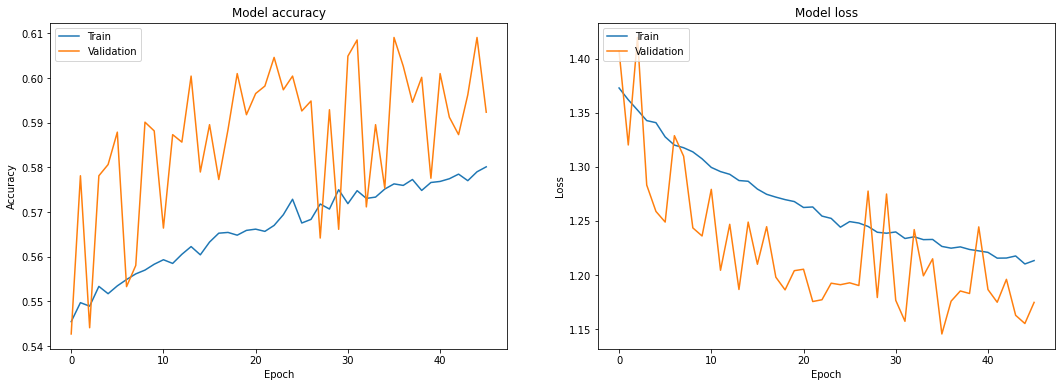

Found 3589 images belonging to 8 classes.
56/56 [==============================] - 1s 25ms/step - loss: 1.1134 - accuracy: 0.6161
Performance on test_set fer2013plus: loss: 1.113423 - acc: 0.616071


In [6]:
model == keras.models.load_model('./FER_model.h5')
model = train_model(model, epochs=200, batch_size=32, visualize=True)
model.save('./FER_model.h5')
evaluate_model(model)

**整个过程训练集、验证集的情况都逐渐转好，只是速度很慢，数据集的庞大和网络的复杂性决定了训练的缓慢性，这一次训练后测试集的准确率从59%提升到61%**

**接下来先转到AffectNet数据集上进行训练**

Found 37553 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.
Epoch 1/200
1173/1173 [==============================] - 154s 132ms/step - loss: 2.1237 - accuracy: 0.3752 - val_loss: 1.7200 - val_accuracy: 0.4223
Epoch 2/200
1173/1173 [==============================] - 154s 131ms/step - loss: 1.6993 - accuracy: 0.3988 - val_loss: 1.7037 - val_accuracy: 0.4212
Epoch 3/200
1173/1173 [==============================] - 154s 132ms/step - loss: 1.6638 - accuracy: 0.4103 - val_loss: 1.6193 - val_accuracy: 0.4383
Epoch 4/200
1173/1173 [==============================] - 158s 135ms/step - loss: 1.6447 - accuracy: 0.4136 - val_loss: 1.5836 - val_accuracy: 0.4597
Epoch 5/200
1173/1173 [==============================] - 156s 133ms/step - loss: 1.6340 - accuracy: 0.4188 - val_loss: 1.7877 - val_accuracy: 0.3932
Epoch 6/200
1173/1173 [==============================] - 161s 137ms/step - loss: 1.6248 - accuracy: 0.4218 - val_loss: 1.6680 - val_accuracy: 0.4265
Epoch 7/200
1173/1173

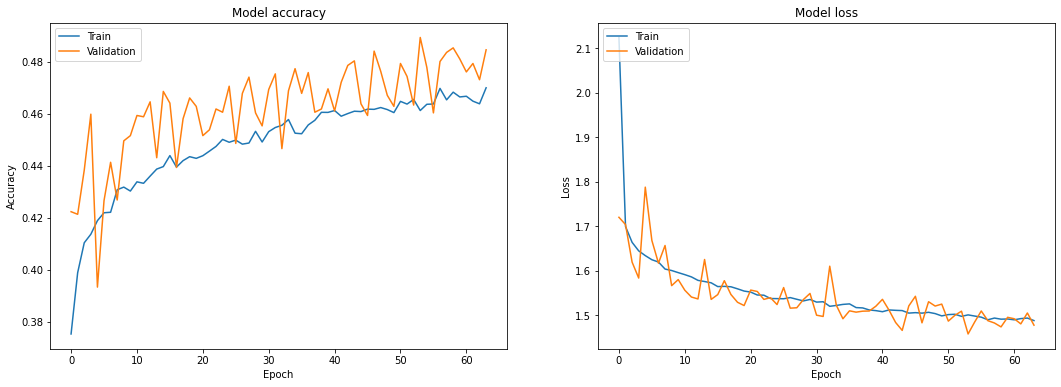

Found 4000 images belonging to 8 classes.
62/62 [==============================] - 19s 303ms/step - loss: 1.4585 - accuracy: 0.4884
Performance on test_set AffectNet: loss: 1.458465 - acc: 0.488407


In [7]:
model == keras.models.load_model('./FER_model.h5')
model = train_model(model, epochs=200, batch_size=32, src='AffectNet', visualize=True)
model.save('./FER_model.h5')
evaluate_model(model, src='AffectNet')

**在模型刚转到AffectNet数据集上时，情况并不是很好，可能这一CNN网络难以在两个数据集上同时取得较好的表现，我的主要任务是力求模型在实际场景中的泛化能力，为此我需要把模型在不同数据集上的表现进行折中**